In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
# Step 1: Load the processed data
file_path = '../data/final_team_cluster_data2.csv'
final_team_cluster_data = pd.read_csv(file_path)

In [19]:
# Add league information from the matches dataset
matches_file_path = '../data/ginf.csv'
matches_data = pd.read_csv(matches_file_path)
team_league_map = pd.concat([matches_data[['ht', 'league']], matches_data[['at', 'league']].rename(columns={'at': 'ht'})])
team_league_map = team_league_map.drop_duplicates().set_index('ht')['league'].to_dict()
final_team_cluster_data['league'] = final_team_cluster_data['event_team'].map(team_league_map)

In [20]:
# Verify that league column was added correctly
print(final_team_cluster_data[['event_team', 'league']].head())

          event_team league
0         AC Ajaccio     F1
1           AC Milan     I1
2         AJ Auxerre     F1
3          AS Monaco     F1
4  AS Nancy Lorraine     F1


In [21]:
# Step 2: Prepare data for clustering
team_names = final_team_cluster_data['event_team']
league_labels = final_team_cluster_data['league']  # Actual league labels
clustering_features = final_team_cluster_data.drop(columns=['event_team', 'league'])

In [22]:
# Step 3: Apply BIRCH Clustering
birch_model = Birch(n_clusters=5, threshold=0.5)
birch_model.fit(clustering_features)
final_team_cluster_data['cluster'] = birch_model.labels_

In [23]:
# Evaluate Clustering Results
# Compute silhouette score
if len(set(birch_model.labels_)) > 1:
    silhouette = silhouette_score(clustering_features, birch_model.labels_)
    print(f"Silhouette Score: {silhouette:.2f}")
else:
    print("Silhouette Score: Cannot compute (only one cluster)")

Silhouette Score: 0.14


In [24]:
# Step 4: Assign a League to Each Cluster
# Create a DataFrame with cluster and league labels
cluster_league_df = final_team_cluster_data[['cluster', 'league']]

In [25]:
# Determine the most common league in each cluster
cluster_to_league = (
    cluster_league_df.groupby('cluster')['league']
    .agg(lambda x: x.value_counts().index[0])  # Most frequent league
    .to_dict()
)
print("\nMost Common League for Each Cluster:")
for cluster, league in cluster_to_league.items():
    print(f"Cluster {cluster}: {league}")


Most Common League for Each Cluster:
Cluster 0: E0
Cluster 1: D1
Cluster 2: SP1
Cluster 3: SP1
Cluster 4: F1


In [26]:
# Step 5: Predict Leagues for Each Team Based on Cluster
final_team_cluster_data['predicted_league'] = final_team_cluster_data['cluster'].map(cluster_to_league)

In [27]:
# Step 6: Compute Accuracy
correct_predictions = final_team_cluster_data['predicted_league'] == final_team_cluster_data['league']
accuracy = correct_predictions.mean()
print(f"\nClustering Accuracy: {accuracy:.2f}")


Clustering Accuracy: 0.46


In [28]:
# Step 7: Evaluate Metrics
ari = adjusted_rand_score(league_labels, final_team_cluster_data['cluster'])
homogeneity = homogeneity_score(league_labels, final_team_cluster_data['cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Homogeneity Score: {homogeneity:.2f}")

Adjusted Rand Index (ARI): 0.16
Homogeneity Score: 0.27


In [29]:
# Cluster size distribution
cluster_counts = pd.Series(birch_model.labels_).value_counts()
print("\nCluster Size Distribution:")
print(cluster_counts)


Cluster Size Distribution:
4    68
3    33
0    22
2    12
1     7
Name: count, dtype: int64


In [30]:
# Step 8: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)
final_team_cluster_data['pca_x'] = pca_features[:, 0]
final_team_cluster_data['pca_y'] = pca_features[:, 1]

Text(0, 0.5, 'PCA Component 2')

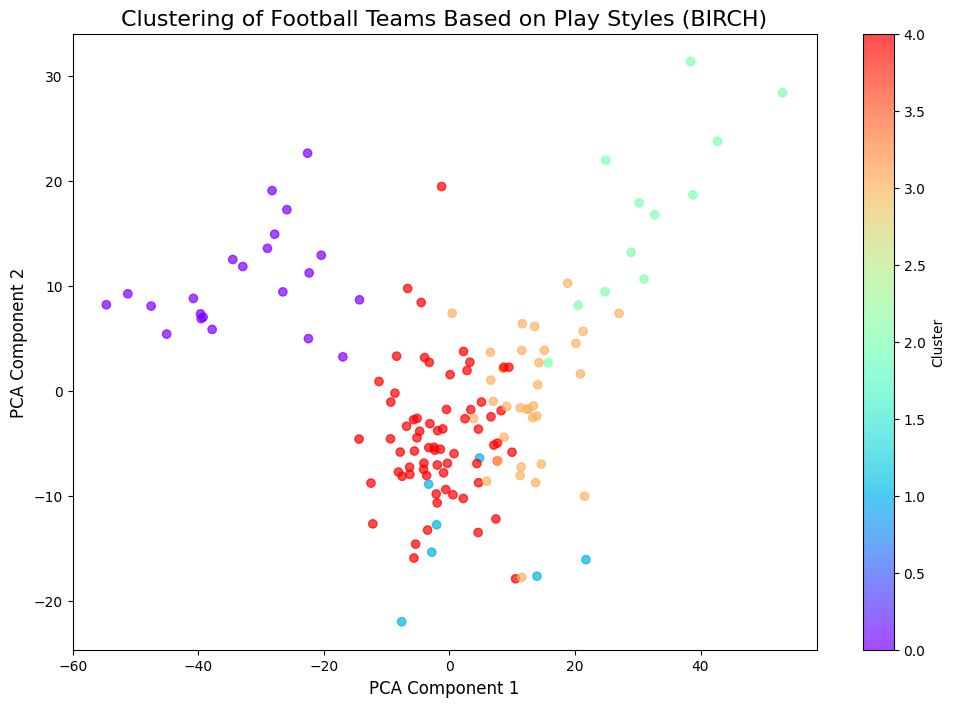

In [31]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_team_cluster_data['pca_x'], 
    final_team_cluster_data['pca_y'], 
    c=final_team_cluster_data['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering of Football Teams Based on Play Styles (BIRCH)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

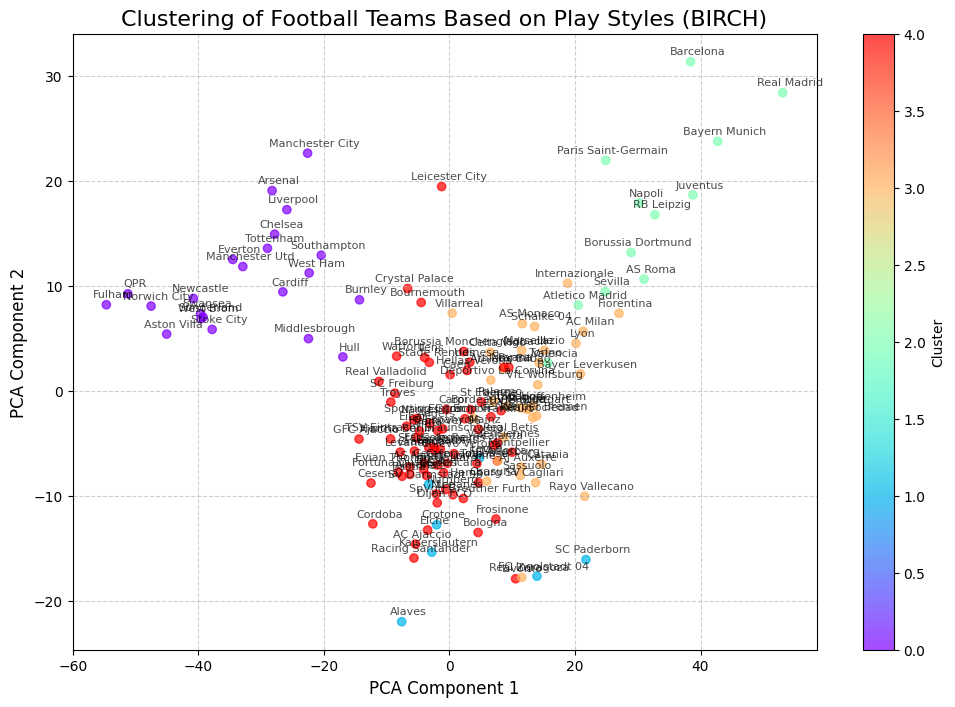

In [32]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_team_cluster_data['pca_x'], 
    final_team_cluster_data['pca_y'], 
    c=final_team_cluster_data['cluster'], 
    cmap='rainbow', 
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering of Football Teams Based on Play Styles (BIRCH)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Annotate team names
for i, team in enumerate(team_names):
    plt.annotate(
        team,
        (final_team_cluster_data['pca_x'][i], final_team_cluster_data['pca_y'][i]),
        fontsize=8,
        alpha=0.7,
        textcoords="offset points",
        xytext=(5, 5),
        ha='center'
    )
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()